In [12]:
%matplotlib inline
import pylab 
from scipy.stats.stats import pearsonr   as corr
import numpy as np
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.feature_selection as sel
from matplotlib import cm as c
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
from sklearn.neighbors import NearestNeighbors as NN
from scipy import stats

/home/andreas/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## function *model*
this function is makes a linear model with automatic feature selection. 
### Inputs:
**d**       the data frame

**gas:**    True for gas prediciton, False for oil predicition

**AL**:     maximum p value for feature selection with fisher-test. Use this paramater to adjust feature selection
### outputs: 
outprints of the variance of the target, the residuals variance, and KS- test.

Also some plots



In [ ]:
def model(d,gas=True,AL=0.05):
    ind=list(d.columns)
    ind.remove('Zone')
    ind.remove('API')
    ind.remove('GasCum360')
    ind.remove('group')
    ind.remove('OilCum360')
    ind.append('GasCum360')
    ind.append('OilCum360')
    d=d.loc[:,ind]
    x=d.loc[:,ind]
    #########################
    x=np.array(x)
    if(gas):
        yg=x[:,42]# gas prediction
    else:
        yg=x[:,43]# pil prediction
  
    ## cut off target   
    a=x[:,:42]
     # normalize the data  
    scaler = StandardScaler()
    X=np.array(scaler.fit_transform(a))
     
    pca = PCA()
    pca.fit(X)
    xx=pca.transform(X)
    selector = sel.VarianceThreshold(threshold=0.05) # features with variances lower than this  will be removed# normal value_0.5
    xx=selector.fit_transform(xx)
    
    p_vals=sel.f_regression(xx,yg)[1]
    F=sel.f_regression(xx,yg)[0]
    
   
    for i in range(len(p_vals)):## not important
        if np.isnan(p_vals[i]):
            p_vals[i]=2# secure handilng for n small
       
    sign_features_ind=[]
    sign_features_ind=[i for i in range(len(p_vals)) if p_vals[i] < AL] # indices of the significant features
    xx2=xx[:,sign_features_ind]### use only significant features for linear model
    XX=sm.add_constant(xx2)
    model=sm.OLS(yg,XX)
    result=model.fit()
    resids=result.resid
    params=result.params

    ############################# histograms and other plots
    f, axarr = plt.subplots(ncols=1,nrows=2,sharex=True)
    
    normd=np.random.normal(0,np.std(resids),len(d))
  
    bin=[i/4 for i in range(-5,12)]
    axarr[0].hist(resids)
    axarr[0].set_title('Resisuals')
    axarr[1].hist(normd)
    axarr[1].set_title('normal Sample of same size')
    
    pred=np.dot(XX,params)
    plt.figure() 
    plt.scatter(pred,resids)# 
    
    plt.title('residuals vs fitted')
    plt.xlabel('fitted')
    plt.figure()
    plt.scatter(yg,resids)#
    plt.title('residuals vs target')
    print(result.summary())
    print('var: ' +str(np.var(yg)))# 
    print('var res: ' +str(np.var(resids)))# 
    print(stats.kstest(resids/np.std(resids),'norm')) 
    plt.figure()
    plt.ylim(-2.5,2.5)
    stats.probplot(resids/np.std(resids), dist="norm",plot=plt,fit=False)
    hline=[i/10 for i in range(-20,20)]
    plt.plot(hline,hline,color='black')
   
    

## function *Lm *
is doing the same as function "model". The difference is that this function is used inside the the function "find_split". So it does not have all the plots and printous. Instead it has a return object.

### Inputs
see function "model"

### Outputs
a list with two elements:

**result** a result object containing all the info abt a lin model

**res_var** the residuals' varicance of the model

In [15]:
def lm(d,gas=True,AL=0.05):
    ind=list(d.columns)
    ind.remove('Zone')
    ind.remove('API')
    ind.remove('GasCum360')
    ind.remove('group')
    ind.remove('OilCum360')
    ind.append('GasCum360')
    ind.append('OilCum360')
    d=d.loc[:,ind]
    x=d.loc[:,ind]
    #########################
    x=np.array(x) 
    if(gas):
        yg=x[:,42]# gas prediction
    else:
        yg=x[:,43]# pil prediction
    ## cut off target   
    a=x[:,:42]
     # normalize the data  
    scaler = StandardScaler()
    X=np.array(scaler.fit_transform(a))
     
    pca = PCA()
    pca.fit(X)
    xx=pca.transform(X)
    selector = sel.VarianceThreshold(threshold=0.05) # features with variances lower than this  will be removed# normal value_0.5
    xx=selector.fit_transform(xx)
    
    p_vals=sel.f_regression(xx,yg)[1]
    F=sel.f_regression(xx,yg)[0]
    
   
    for i in range(len(p_vals)):## not important
        if np.isnan(p_vals[i]):
            p_vals[i]=2# secure handling for n small
       
    sign_features_ind=[]
    sign_features_ind=[i for i in range(len(p_vals)) if p_vals[i] < AL] # indices of the significant features
    xx2=xx[:,sign_features_ind]### use only significant features for linear model
    XX=sm.add_constant(xx2)
    model=sm.OLS(yg,XX)
    result=model.fit()
    resids=result.resid
    res_var=np.var(resids)
    return [result,res_var]

    
   
    

## function *find_split*
This function loops over all features and all attributes to find the best split.

**Splitting Criteria:** The weighted average over the residual variance of the two resulting linear models.

So the function computes two linear models for every attribute at every possible treshold. This is computationally intensive, but it works if the step is not too small or the attributes list is limited (see Inputs).

### Inputs:

**d**  Data Frame

**gaz** True for gas prediction, False for Oil Prediction

**step ( default= 10)**  determines how fine the treshold search is made for each attribute. If the step is 1, every possible split is tried. This takes too long. step= 5 takes like 20 seconds, depending on the machine

**attr (default= empty list)** If not given, the function will loop over all attributes. If given, it should be a list of strings with names of the attributes that the split search loops over. This parameter is useful when we already pre-filtered the attributed for candidates of a split.

### Outputs:
A Data frame with 4 columns. Each line of the data frame is a possible split. The frame is sorted by the best residual varicance:
**feat** feature name

**mse**  weighted average residual variaance of the resulting model

**breakpoint** integer, giving the number of members of one of the splits

**treshold** value of the attribute where the split was made


In [22]:
def find_split(d,gaz=True,step=10,attr=[]):# 
    mses=[]
    features=[]
    breakpoints=[]
    thresholds=[]
    if(len(attr)==0):
        attr=list(d.columns)
        attr.remove('GasCum360')
        attr.remove('OilCum360')
    
    minv=20# minimum variance of the best split
    min_ind="bla"#index at wihch position the best split is made
    n=0# optimal index for the feature currently in the for loop
    var=20
    l=len(d)
    print()
    if(gaz):
        target='GasCum360'
    else:
        target='OilCum360'
    v=np.var(d[target])
    print('target variance: '+str(v))
    print('--------------------------------')
    for indexx in attr:
        features.append(indexx)
        d=d.sort_values(indexx)
        in_var=20 # min var of current loop
        in_n=0#  best index of current loop
        for i in range(10,l-10,step):
            d1=d.iloc[:i]
            d2=d.iloc[i:]
            mse1=lm(d1,gas=gaz)[1]
            mse2=lm(d2,gas=gaz)[1]
            var=(mse1*i+ mse2*(l-i))/l
            if var < in_var:
                in_var=var
                in_n=i
        mses.append(in_var)
        breakpoints.append(in_n)
        thresholds.append(d.iloc[in_n][target])
        if in_var < minv:
            minv=in_var
            min_ind=indexx
            n=in_n
        u=np.zeros((len(features),4))
        u=pd.DataFrame(u)
        u.columns=['feat','mse','breakpoint','threshold']
        u['feat']=features
        u['mse']=mses
        u['breakpoint']=breakpoints
        u['threshold']= thresholds
        u=u.sort_values('mse')
    return u

## function *findtr*
Similar to "find_split", this function loops over all attributes and over all possible splits.
 
**Difference:** This function just computes the weighted avarage of the variance of the two sets that were created by the split. So it is a lot less complex than "find_split".

### Input 

**d** Data Frame

**target (default = 'GasCum360')** target name as a string

### Output

A sorted ( by average variance) data frame similar to the one of "find_split". 

** feat**  feature name

** mse ** weighted average of the variances

** cor** correlation between feature and target.

** treshold**  same as "find_split"

In [34]:
def findtr(d,target='GasCum360'):
    mses=[]
    features=[]
    cor=[]
    thresholds=[]
    ind2=list(d.columns)
    ind2.remove('GasCum360')
    ind2.remove('OilCum360')
    minv=20
    min_ind="bla"
    n=0
    var=20
    l=len(d)
    print()
    v=np.var(d[target])
    print('target variance: '+str(v))
    print('--------------------------------')
    for indexx in ind2:
        d=d.sort_values(indexx)
        in_var=20
        in_n=0
        for i in range(2,l-2):
            var=(np.var(d.iloc[:i][target])*i+np.var(d.iloc[i:][target])*(l-i))/l
            if var < in_var:
                in_var=var
                in_n=i
        if in_var < minv:
            minv=in_var
            min_ind=indexx
            n=in_n
        features.append(indexx)
        mses.append(in_var)
        cor.append(d[target].corr(d[indexx]))
        thresholds.append(d.iloc[in_n][target])
    u=np.zeros((len(features),4))
    u=pd.DataFrame(u)
    u.columns=['feat','mse','cor','threshold']
    u['feat']=features
    u['mse']=mses
    u['cor']=cor
    u['threshold']= thresholds
    u=u.sort_values('mse')
    return u

# Example
Load the data , take only group 2 ( high gas) and filter out some outliers

In [36]:
df=pd.read_csv('partitionned_train_final.csv',sep=',')
df=df.loc[:,'API':]
rows=df[~df['Nbr_Stages'].isnull()].index
df2=df.loc[rows,:]
df2=df2[df2['group']==2].copy()
df2=df2[df2['Zone']!=0].copy()
df2=df2[df2['GasCum360']<=2].copy()
df2=df2[df2['GasCum360']>-0.8].copy()





**Make a first linear model on all the data of group 2 ( 141 objects ).**

[ 10.15368222 -10.20678934   3.46056322   4.48277998  -4.14243212
  -5.94698659   4.02848937  -4.21483921]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     31.82
Date:                Sat, 17 Feb 2018   Prob (F-statistic):           1.41e-25
Time:                        19:54:01   Log-Likelihood:                -87.008
No. Observations:                 141   AIC:                             190.0
Df Residuals:                     133   BIC:                             213.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

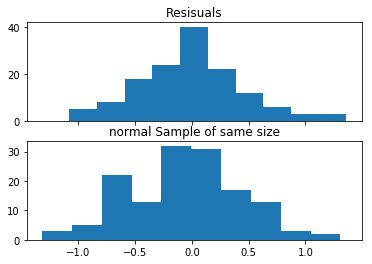

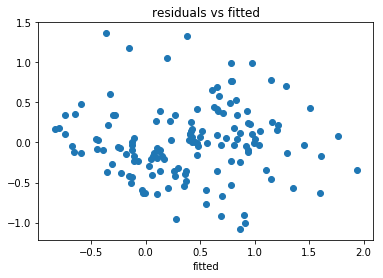

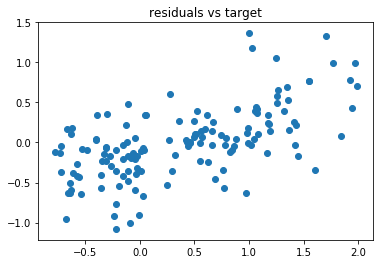

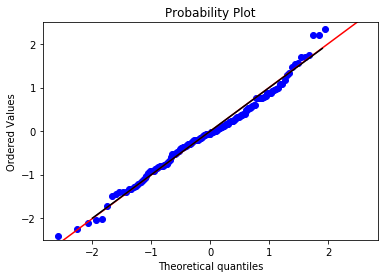

In [109]:
model(df2)# res vs fitted is a problem

We can be satisfied with the normality of residuals ( oultiers are already removed), however, the residuals vs target plot shows, that the linearity assumption does not really hold.


## Finding a split in a Two Step Process uising "find_split"
### Step 1
To not exceed the computation time, we make a first run with a bigger iteration step (= 5)
and save the 10 best candidates. Takes around 20 seconds

In [37]:
z=find_split(df2,step=5)
cand=z.head(10)['feat'].values # 10 best candifates



target variance: 0.538056301818
--------------------------------


In [38]:
z.head(5)

,feat,mse,breakpoint,threshold
36,ShutInPressure_Initial (KPa),0.145511,65,-0.607415
24,Nbr_Stages,0.149383,60,0.054385
3,Lateral_Length (ft),0.151438,115,0.823456
38,Shot_Density (shots/ft),0.158415,75,-0.024182
1,Surf_X,0.162523,50,0.743207


### Step 2 
Now we take the candidates list and make a finer search

In [39]:
z2=find_split(df2,step=2,attr=cand)


target variance: 0.538056301818
--------------------------------


In [40]:
z2.head(5)

,feat,mse,breakpoint,threshold
0,ShutInPressure_Initial (KPa),0.144896,64,0.456733
1,Nbr_Stages,0.149383,60,-0.359815
7,Temperature (F),0.149977,18,0.054385
2,Lateral_Length (ft),0.152157,116,1.350653
3,Shot_Density (shots/ft),0.160869,120,1.601769


** We notice a small changement in the ranking and adjusted breakpoints, but no major differences**
We opt for Nbr-Stages. Did not have too much imputation during cleaning.

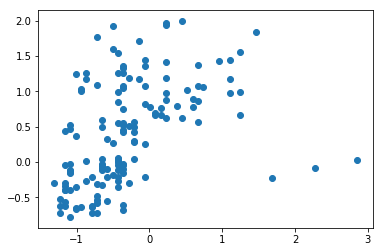

In [44]:
plt.scatter(df2['Nbr_Stages'],df2['GasCum360'])

In [45]:
dfa=df2[df2['Nbr_Stages']< 0.055]
dfb=df2[df2['Nbr_Stages']>= 0.055]

[ 4.95837875 -7.05392122  5.88413759  4.24391276  3.95979651 -4.73711214
  3.69067409]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     25.69
Date:                Sun, 18 Feb 2018   Prob (F-statistic):           2.40e-18
Time:                        18:45:00   Log-Likelihood:                -63.188
No. Observations:                 108   AIC:                             140.4
Df Residuals:                     101   BIC:                             159.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

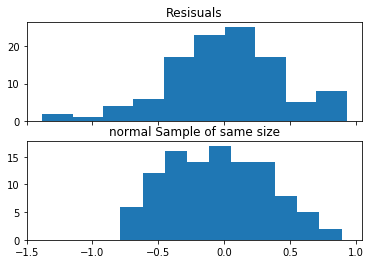

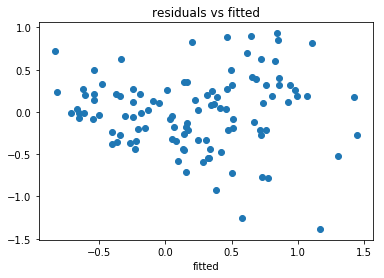

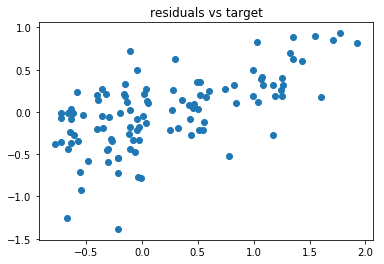

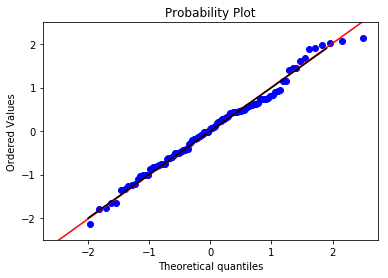

In [46]:
model(dfa)# res vs fitted is a problem

the plot residuals vs fitted is still not satisfying.

[ 13.86693711  -4.20326822   2.89544142]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     13.03
Date:                Sat, 17 Feb 2018   Prob (F-statistic):           8.47e-05
Time:                        19:54:36   Log-Likelihood:                -15.699
No. Observations:                  33   AIC:                             37.40
Df Residuals:                      30   BIC:                             41.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

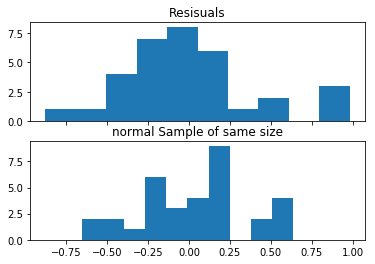

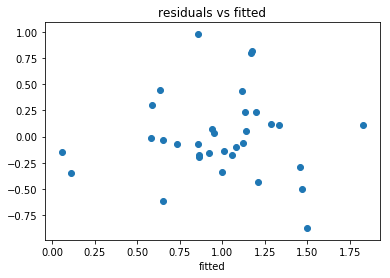

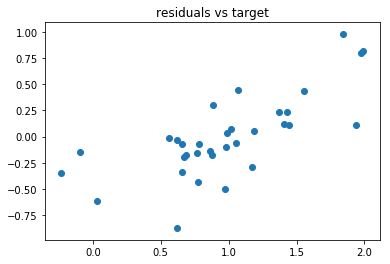

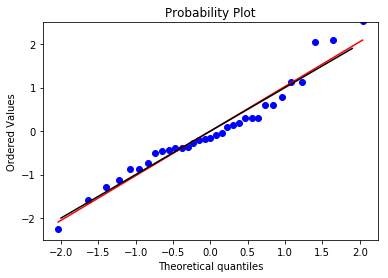

In [110]:
model(dfb)# ok, not bad, apart from outliers

with this half of the data, we find a satisfying model.
## make another split for dfa
because res vs fitted tells us we should not use a linear model

In [47]:
z=find_split(dfa,step=5)
cand=z.head(10)['feat'].values # 10 best candifates


target variance: 0.476604565166
--------------------------------


In [51]:
z.head()

,feat,mse,breakpoint,threshold
6,Pressure_PPLS (PSI),0.143068,30,-0.404306
9,Vsand_PPLS,0.154003,95,1.080719
33,Max_Treating_pressure (KPa),0.155262,60,1.254992
41,Stage_Spacing (ft),0.156077,65,-0.058856
10,Vclay_PPLS,0.159412,35,0.996114


In [55]:
z2=find_split(dfa,step=2,attr=cand)


target variance: 0.476604565166
--------------------------------


In [56]:
z2.head(7)

,feat,mse,breakpoint,threshold
0,Pressure_PPLS (PSI),0.142438,68,-0.359815
4,Lateral_Length (ft),0.150606,34,-0.041386
3,Stage_Spacing (ft),0.151942,66,-0.193303
2,Max_Treating_pressure (KPa),0.155262,60,1.254992
6,deltaT_Comp_Prod,0.156164,12,-0.359815
8,Shot_Density (shots/ft),0.161692,56,-0.108699
9,Avg_Breakdown_Pressure (KPa),0.162171,10,-0.576744


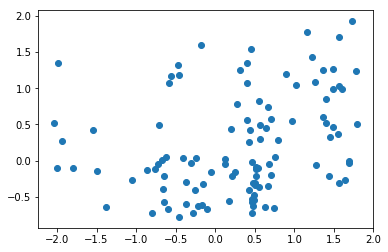

In [60]:
plt.scatter(dfa['Pressure_PPLS (PSI)'],dfa['GasCum360'])

**We split by "Pressure_PPLS"**

In [49]:
dfaa=dfa[dfa['Pressure_PPLS (PSI)']< 0.143]
dfab=dfa[dfa['Pressure_PPLS (PSI)']>= 0.143]

[ 0.0481801  -6.02496957 -4.10315968]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     26.57
Date:                Sun, 18 Feb 2018   Prob (F-statistic):           7.02e-08
Time:                        18:49:26   Log-Likelihood:                -20.644
No. Observations:                  40   AIC:                             47.29
Df Residuals:                      37   BIC:                             52.36
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

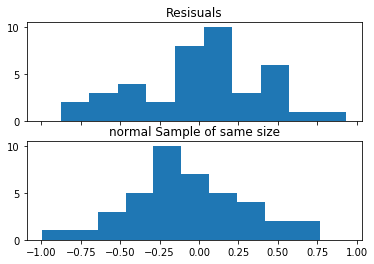

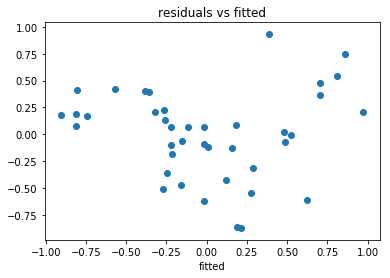

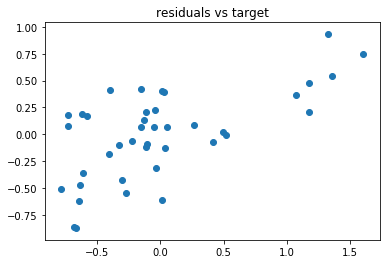

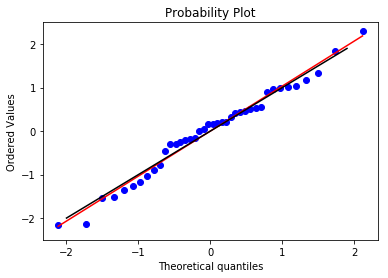

In [50]:
model(dfaa)# residuals vs fitted is a problem

**Again, for this half of the split, the residuals vs fitted plot lets us assume that the linearity assumption does not hold** We will need another split or sth else.

[ 6.16867102  5.15557053 -3.34529053  4.12801644 -5.62446936 -3.30302889]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     19.47
Date:                Sun, 18 Feb 2018   Prob (F-statistic):           1.32e-11
Time:                        18:49:27   Log-Likelihood:                -39.422
No. Observations:                  68   AIC:                             90.84
Df Residuals:                      62   BIC:                             104.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

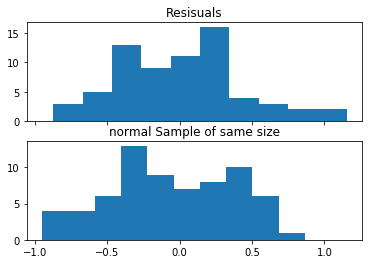

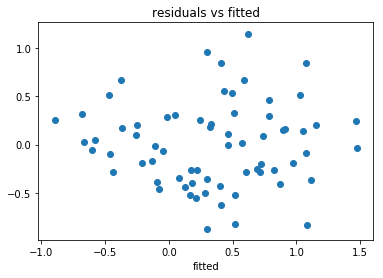

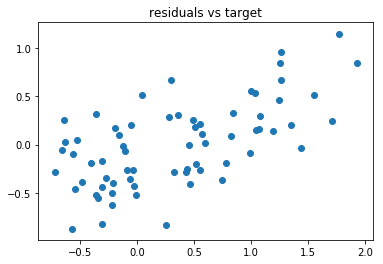

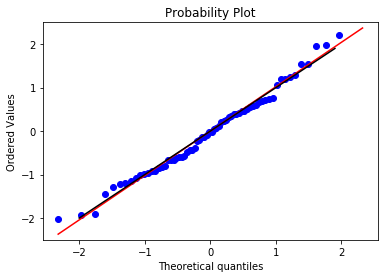

In [51]:
model(dfab)# residuals vs fitted is ok

## conclusion: 
**To Sum up we have the following final subsets:** ( only leaves of the splitting tree will be mentioned.)

**dfb**   33 observations, model ok

**dfaa**   40 observations,  problem with linearity assumption

**dfab**   68 observations, model is ok


**We can conculde that by making splits, we manage to fulfil the model assumptions for 2 of 3 subsets**
The non- linearity for dfaa could eventually be resolved by making another split, the problem is that the number of observations will get too small.

 

## Example of *findtr*

In [57]:
z=findtr(dfa)
z.head(7)


target variance: 0.476604565166
--------------------------------


,feat,mse,cor,threshold
4,Depth_TVD_PPLS (ft),0.350646,-0.518314,-0.216610
3,Lateral_Length (ft),0.367591,0.483547,0.990852
26,Proppant_Designed (kg),0.367806,0.471166,0.990852
27,Proppant_in_Formation (kg),0.372815,0.468941,1.773145
20,S3Tect_PPLS (PSI),0.373136,-0.321121,0.361823
2,Surf_Y,0.377760,0.483742,0.456733
6,Pressure_PPLS (PSI),0.381583,0.283141,1.190444


We see that the ranking of candidates is different using the *findr* function. Maybe we should retry the split of dfa using *Depth_TVD_PPLS (ft)*